In [59]:
import sqlite3
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [60]:
conn = sqlite3.connect('../data/ChronicHealthTrends.db')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()  # List of all tables

# Print the table names
print("Tables:", tables)

# Load the first table (for example)
table_name = "MonthlyProvisionalCountsofDeathsbySelectCauses"
df_1 = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Display the DataFrame
print(df_1.head())

# Close the connection
conn.close()


Tables: [('MonthlyProvisionalCountsofDeathsbySelectCauses',), ('USChronicDiseaseIndicators',)]
   Year  Month  All Cause  Natural Cause  Septicemia  Malignant Neoplasms  \
0  2020      1     264681         242914        3687                52635   
1  2020      2     244966         224343        3324                48764   
2  2020      3     269806         247634        3669                51640   
3  2020      4     322424         300780        3366                48773   
4  2020      5     280564         255489        3085                49012   

   Diabetes Mellitus  Alzheimer Disease  Influenza and Pneumonia  \
0               8234              11122                     6656   
1               7766              10444                     6147   
2               8433              11385                     7579   
3               9440              12307                     5781   
4               8361              10706                     3612   

   Chronic Lower Respiratory Dise

In [61]:
conn = sqlite3.connect('../data/ChronicHealthTrends.db')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()  # List of all tables

# Print the table names
print("Tables:", tables)

# Load the first table (for example)
table_name = "USChronicDiseaseIndicators"
df_2 = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Display the DataFrame
print(df_2.head())

# Close the connection
conn.close()


Tables: [('MonthlyProvisionalCountsofDeathsbySelectCauses',), ('USChronicDiseaseIndicators',)]
   YearStart LocationAbbr   LocationDesc    Topic          DataValueType  \
0       2019           US  United States  Alcohol       Crude Prevalence   
1       2011           US  United States  Alcohol       Crude Prevalence   
2       2018           US  United States  Alcohol       Crude Prevalence   
3       2017           US  United States   Asthma             Crude Rate   
4       2013           US  United States   Cancer  Average Annual Number   

  DataValue  LowConfidenceLimit  HighConfidenceLimit StratificationCategory1  \
0      13.9           10.400000             18.40000          Race/Ethnicity   
1                     41.815759             44.35189                 Overall   
2      67.4           66.500000             68.30000          Race/Ethnicity   
3      10.9           10.600000             11.30000                 Overall   
4      9661           41.815759             44.3

In [79]:
import pandas as pd

# Assume chronic (df_2) and death (df_1) are already loaded as DataFrames
chronic = df_2  # Replace with actual data loading
death = df_1    # Replace with actual data loading

# Define a mapping for the cause of death to disease type
cause_to_disease = {
    'Diseases of Heart': 'Cardiovascular Disease',
    'Malignant Neoplasms': 'Cancer',
    'Diabetes Mellitus': 'Diabetes',
    'Chronic Lower Respiratory Diseases': 'Chronic Obstructive Pulmonary Disease',
    'Intentional Self-Harm (Suicide)': 'Mental Health',
    # Add more mappings as needed
}

# Step 1: Filter Chronic data for relevant columns and years (2020, 2021)
chronic_filtered = chronic[(chronic['YearStart'].isin([2020, 2021])) & 
                           (chronic['DataValueType'].isin(['Crude Prevalence', 'Age-adjusted Prevalence']))].copy()

# Ensure DataValue is numeric
chronic_filtered['DataValue'] = pd.to_numeric(chronic_filtered['DataValue'], errors='coerce')
chronic_filtered = chronic_filtered.dropna(subset=['DataValue'])

# Sum the DataValue for each Topic and YearStart
chronic_grouped = chronic_filtered.groupby(['Topic', 'YearStart'], as_index=False)['DataValue'].sum()
chronic_grouped.rename(columns={'DataValue': 'Prevalence'}, inplace=True)

# Step 2: Filter Death data for relevant columns and years (2020, 2021)
death_filtered = death[death['Year'].isin([2020, 2021])]

# Step 3: Reshape the death data from wide to long format
death_long = pd.melt(death_filtered, id_vars=['Year'], var_name='Cause of Death', value_name='DeathRate')

# Map Cause of Death to Disease
death_long['Disease'] = death_long['Cause of Death'].map(cause_to_disease)

# Filter out rows where Disease is not available
death_long_filtered = death_long.dropna(subset=['Disease'])

# Step 4: Merge the Chronic and Death data on Disease and Year
final_df = pd.merge(
    chronic_grouped.rename(columns={'Topic': 'Disease'}),
    death_long_filtered[['Disease', 'Year', 'DeathRate']],
    left_on=['Disease', 'YearStart'],
    right_on=['Disease', 'Year'],
    how='inner'
)

# Drop unnecessary columns and clean up the final DataFrame
final_df = final_df.drop(columns=['Year'])
print(final_df)
final_df = final_df.groupby(['Disease', 'YearStart'], as_index=False)[['Prevalence', 'DeathRate']].sum()

print("Final DataFrame (Disease-Level):")
# print(final_df)

print("\nYearly Summary (Summed by Year):")
# print(final_yearly_summary)

# # Step 5: Create a connection to SQLite database and store the final table
conn = sqlite3.connect('health_data.db')

# # Store the DataFrame in SQLite
final_df.to_sql('FinalHealthData', conn, if_exists='replace', index=False)

# # Confirm the data is stored in SQLite
# query = 'SELECT * FROM FinalHealthData LIMIT 10;'  # Display the first 10 rows
# result = pd.read_sql(query, conn)

# # Close the connection
# conn.close()

# # Print the first few rows of the stored data for confirmation
# print(result)


           Disease  YearStart  Prevalence  DeathRate
0           Cancer       2020       827.4    52635.0
1           Cancer       2020       827.4    48764.0
2           Cancer       2020       827.4    51640.0
3           Cancer       2020       827.4    48773.0
4           Cancer       2020       827.4    49012.0
..             ...        ...         ...        ...
103  Mental Health       2021        23.9     4366.0
104  Mental Health       2021        23.9     4232.0
105  Mental Health       2021        23.9     4267.0
106  Mental Health       2021        23.9     3952.0
107  Mental Health       2021        23.9     3898.0

[108 rows x 4 columns]
Final DataFrame (Disease-Level):

Yearly Summary (Summed by Year):


9

In [ ]:
import sqlite3

# Create an SQLite database (or connect to an existing one)
conn = sqlite3.connect('health_data.db')

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Create a table for the final data if it doesn't already exist
cursor.execute('''
    CREATE TABLE IF NOT EXISTS disease_data (
        Disease TEXT,
        Year INTEGER,
        Total_Count INTEGER,
        Prevalence REAL
    )
''')

# Insert the final table data into the SQLite table
for _, row in final_table.iterrows():
    cursor.execute('''
        INSERT INTO disease_data (Disease, Year, Total_Count, Prevalence)
        VALUES (?, ?, ?, ?)
    ''', (row['Disease'], row['Year'], row['Total Count'], row['Prevalence']))

# Commit the changes to the database
conn.commit()

# Close the connection
conn.close()

print("Data has been successfully stored in the SQLite database.")


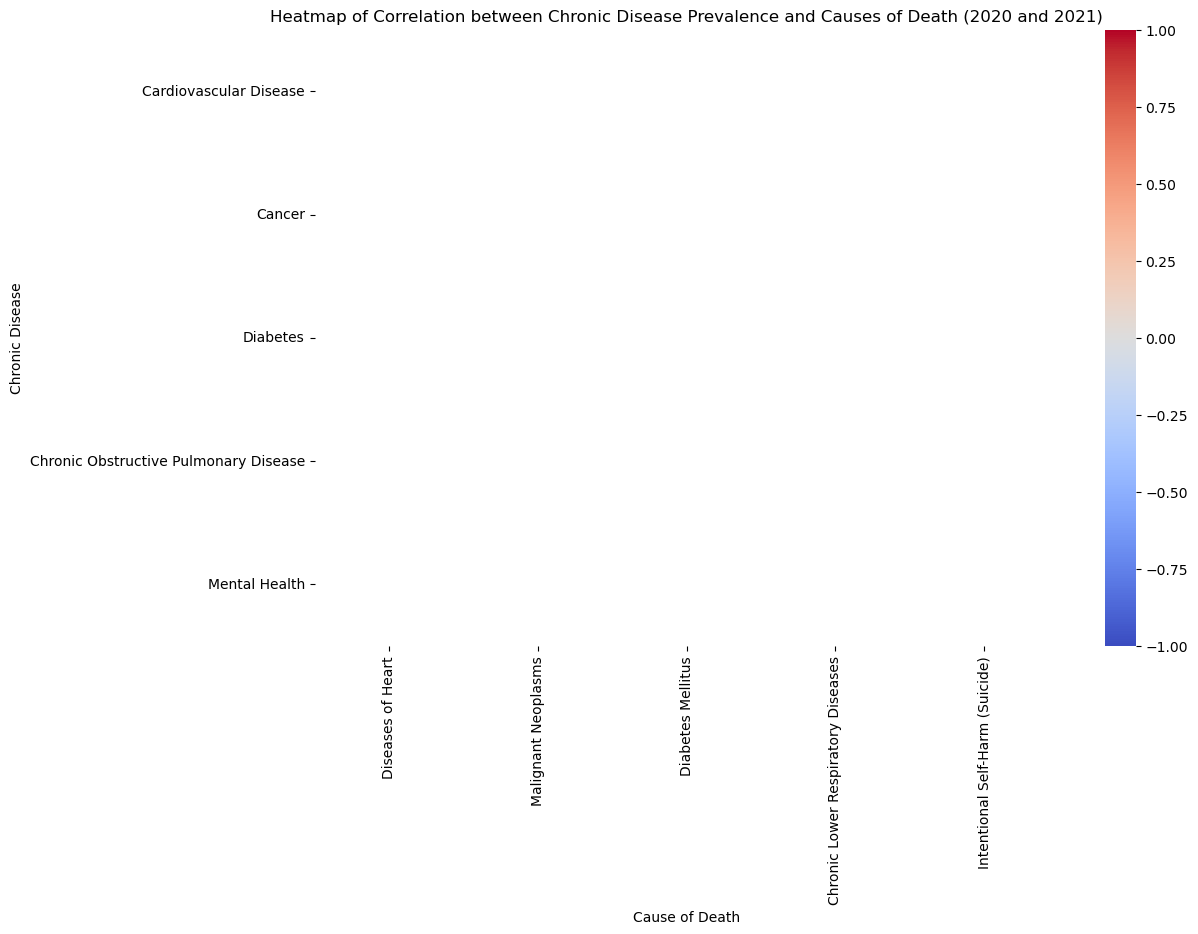

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Updated dictionary of relevant chronic disease indicators and their corresponding causes of death
relevant_death_causes = {
    'Cardiovascular Disease': ['Diseases of Heart'],
    'Cancer': ['Malignant Neoplasms'],
    'Diabetes': ['Diabetes Mellitus'],
    'Chronic Obstructive Pulmonary Disease': ['Chronic Lower Respiratory Diseases'],
}



# Crude Prevalence
# Age-adjusted Prevalence



# Age-adjusted Prevalence
# Crude Prevalence


# Assuming 'df_1' (deaths) and 'df_2' (chronic diseases) are your dataframes
chronic = df_2
deaths = df_1

# Filter chronic data to only include rows with 'Crude Rate' in DataValueType column
chronic = chronic[chronic['DataValueType'] == 'Crude Rate']

# Create 'Year' column based on 'YearStart'
chronic.loc[:, 'Year'] = chronic['YearStart']

# Group by 'Year' and 'Topic', then sum the 'DataValue' (which represents the 'Crude Rate')
chronic_sum = chronic.groupby(['Year', 'Topic'])['DataValue'].sum().reset_index()

# Merge summed data with the deaths data on 'Year'
merged = pd.merge(deaths, chronic_sum, on=['Year'], how='inner')

# Filter merged data to only include rows for the years 2020 and 2021
merged = merged[merged['Year'].isin([2020, 2021])]

# Create an empty matrix to store correlation values
correlation_matrix = pd.DataFrame(index=relevant_death_causes.keys(), columns=[cause for causes in relevant_death_causes.values() for cause in causes])

# Calculate correlations
for chronic_disease, death_causes in relevant_death_causes.items():
    for cause in death_causes:
        # Filter data for the specific chronic disease and death cause
        subset = merged[(merged['Topic'] == chronic_disease) & (merged[cause].notna())]
        
        # Clean data (convert to numeric, remove NaNs and Infs)
        subset.loc[:, 'DataValue'] = pd.to_numeric(subset['DataValue'], errors='coerce')
        subset.loc[:, cause] = pd.to_numeric(subset[cause], errors='coerce')
        
        # Drop rows with NaN or Inf values in both columns
        subset = subset.dropna(subset=['DataValue', cause])
        subset = subset[~subset[['DataValue', cause]].isin([float('inf'), float('-inf')]).any(axis=1)]
        
        if not subset.empty:
            # Option 1: Use Pearson correlation (for linear relationships)
            correlation, _ = pearsonr(subset['DataValue'], subset[cause])
            
            # Option 2: Use Spearman correlation (for non-linear relationships)
            # correlation, _ = spearmanr(subset['DataValue'], subset[cause])
            
            # Store the correlation in the matrix
            correlation_matrix.loc[chronic_disease, cause] = correlation

# Convert correlation values to numeric
correlation_matrix = correlation_matrix.apply(pd.to_numeric, errors='coerce')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Heatmap of Correlation between Chronic Disease Prevalence and Causes of Death (2020 and 2021)')
plt.xlabel('Cause of Death')
plt.ylabel('Chronic Disease')
plt.show()

# Visualize individual scatter plots for further exploration
for chronic_disease, death_causes in relevant_death_causes.items():
    for cause in death_causes:
        subset = merged[(merged['Topic'] == chronic_disease) & (merged[cause].notna())]
        
        # Clean data
        subset.loc[:, 'DataValue'] = pd.to_numeric(subset['DataValue'], errors='coerce')
        subset.loc[:, cause] = pd.to_numeric(subset[cause], errors='coerce')
        subset = subset.dropna(subset=['DataValue', cause])
        
        if not subset.empty:
            plt.figure(figsize=(6, 4))
            plt.scatter(subset['DataValue'], subset[cause], alpha=0.7, label=f'{chronic_disease} vs {cause}')
            plt.xlabel(f'{chronic_disease} Prevalence')
            plt.ylabel(f'{cause} Death Rate')
            
            # Handle NaN in correlation value gracefully
            correlation_value = correlation_matrix.loc[chronic_disease, cause]
            
            # Check if correlation_value is a scalar and not NaN
            if isinstance(correlation_value, pd.Series):  # If it's a Series, extract the scalar value
                correlation_value = correlation_value.iloc[0]
            
            # Now check if it's NaN
            if pd.notna(correlation_value):  # This ensures we're working with a scalar value
                plt.title(f'{chronic_disease} vs {cause} (r={correlation_value:.2f})')
            else:
                plt.title(f'{chronic_disease} vs {cause} (r=NaN)')  # For cases where correlation is NaN
            
            plt.legend()
            plt.show()


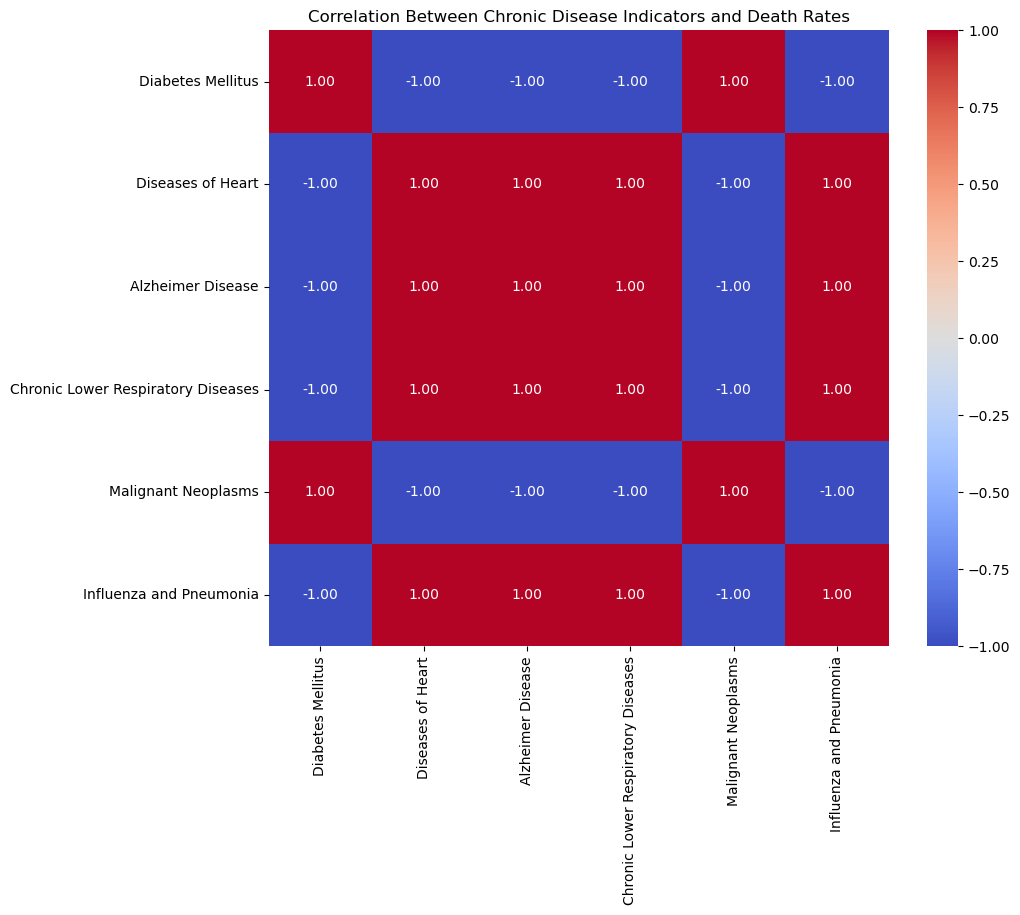

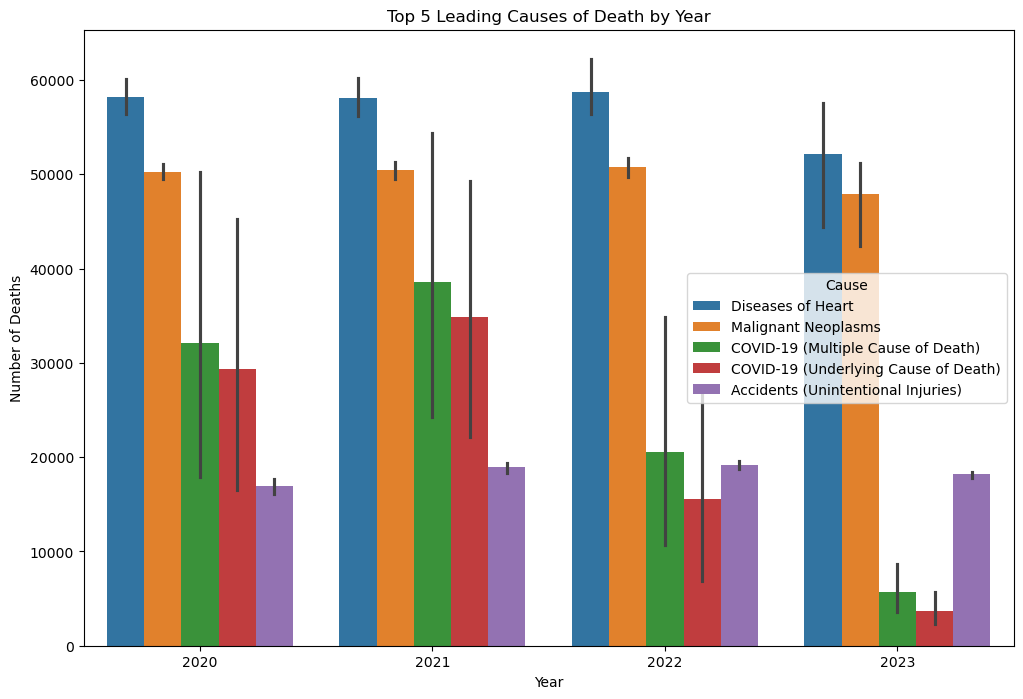

In [26]:
df1 = df_1
df2 = df_2

df1['Year'] = df1['Year'].astype(int)
df1_yearly = df1.groupby("Year").sum()

# Filter relevant years in Table 2 (matching years between both datasets)
df2_filtered = df2[df2["YearStart"].isin(df1_yearly.index)]

# Ensure numeric conversion for correlation analysis (exclude non-numeric columns)
df_merged = pd.merge(df1_yearly, df2_filtered, left_index=True, right_on="YearStart")
columns_of_interest = [
    "Diabetes Mellitus", 
    "Diseases of Heart", 
    "Alzheimer Disease", 
    "Chronic Lower Respiratory Diseases", 
    "Malignant Neoplasms", 
    "Influenza and Pneumonia"
]
df_correlation = df_merged[columns_of_interest].dropna()

# Compute correlations
correlation_matrix = df_correlation.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Chronic Disease Indicators and Death Rates")
plt.show()

# ---- Analysis 2: Top 5 Leading Causes of Death ----
# Extract and rank the top 5 causes of death by year
def find_top_causes(df, top_n=5):
    # Drop non-cause columns
    causes = df.drop(columns=["Month", "All Cause", "Natural Cause"], errors='ignore').set_index("Year")
    yearly_totals = causes.sum()
    top_causes = yearly_totals.nlargest(top_n).index
    return causes[top_causes]

top_causes_df = find_top_causes(df1, top_n=5)

# Melt the dataframe for easier plotting
top_causes_melted = top_causes_df.reset_index().melt(id_vars="Year", var_name="Cause", value_name="Deaths")

# Visualization: Top 5 causes of death by year
plt.figure(figsize=(12, 8))
sns.barplot(data=top_causes_melted, x="Year", y="Deaths", hue="Cause")
plt.title("Top 5 Leading Causes of Death by Year")
plt.ylabel("Number of Deaths")
plt.xlabel("Year")
plt.legend(title="Cause")
plt.show()


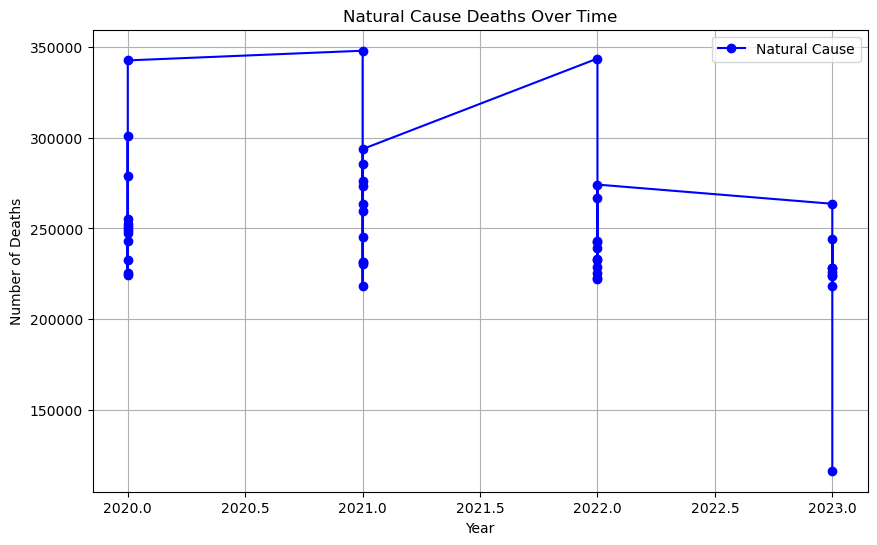

In [16]:
df_deaths = df_1

plt.figure(figsize=(10, 6))
plt.plot(df_deaths['Year'], df_deaths['Natural Cause'], marker='o', color='b', label='Natural Cause')
plt.title('Natural Cause Deaths Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.grid(True)
plt.legend()
plt.show()


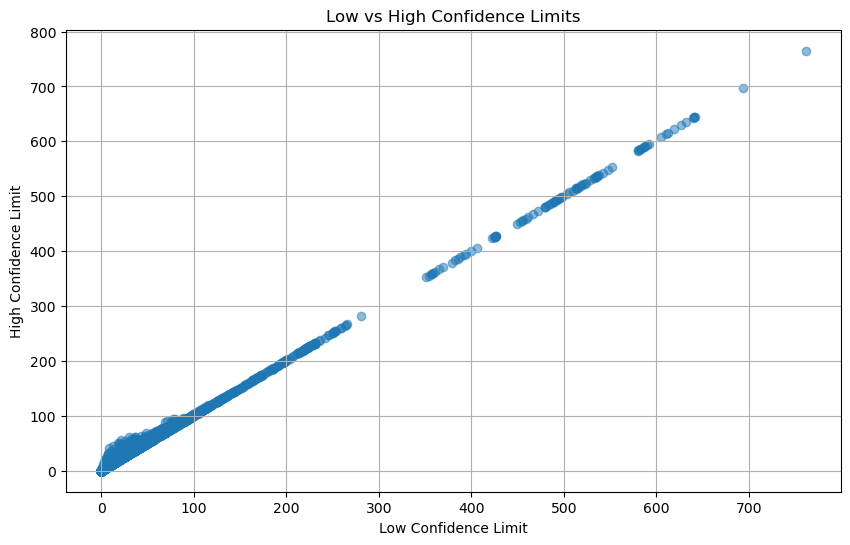

In [17]:
df_chronic = df_2

df_chronic['LowConfidenceLimit'] = pd.to_numeric(df_chronic['LowConfidenceLimit'], errors='coerce')
df_chronic['HighConfidenceLimit'] = pd.to_numeric(df_chronic['HighConfidenceLimit'], errors='coerce')

# Scatter plot of Low vs High Confidence Limits
plt.figure(figsize=(10, 6))
plt.scatter(df_chronic['LowConfidenceLimit'], df_chronic['HighConfidenceLimit'], alpha=0.5)
plt.title('Low vs High Confidence Limits')
plt.xlabel('Low Confidence Limit')
plt.ylabel('High Confidence Limit')
plt.grid(True)
plt.show()

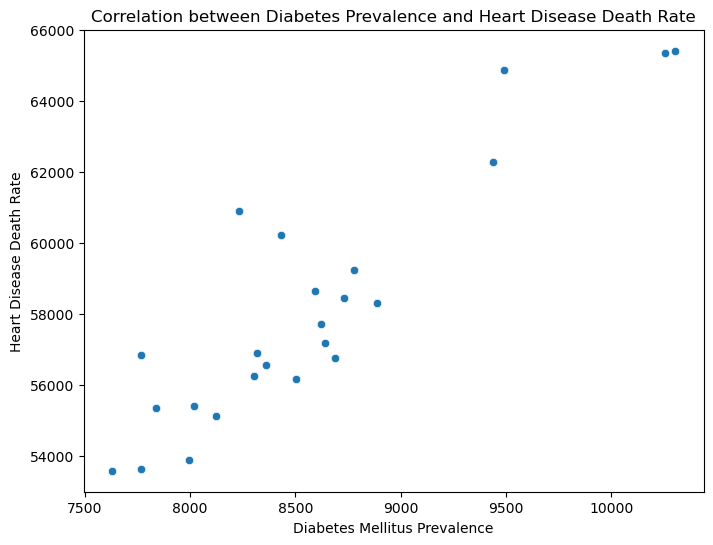

Correlation between Diabetes Mellitus and Heart Disease Death Rate: 0.8887694019390044


In [18]:
deaths_df= df_1
chronic_disease_df=df_2

merged_df = pd.merge(deaths_df, chronic_disease_df, left_on='Year', right_on='YearStart')

# Select relevant columns for analysis (e.g., diabetes prevalence and heart disease death rate)
merged_df = merged_df[['Year', 'Diabetes Mellitus', 'Diseases of Heart']]

# Plot scatter plot for correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=merged_df['Diabetes Mellitus'], y=merged_df['Diseases of Heart'])
plt.title('Correlation between Diabetes Prevalence and Heart Disease Death Rate')
plt.xlabel('Diabetes Mellitus Prevalence')
plt.ylabel('Heart Disease Death Rate')
plt.show()

# Calculate the correlation coefficient
correlation = merged_df['Diabetes Mellitus'].corr(merged_df['Diseases of Heart'])
print(f'Correlation between Diabetes Mellitus and Heart Disease Death Rate: {correlation}')

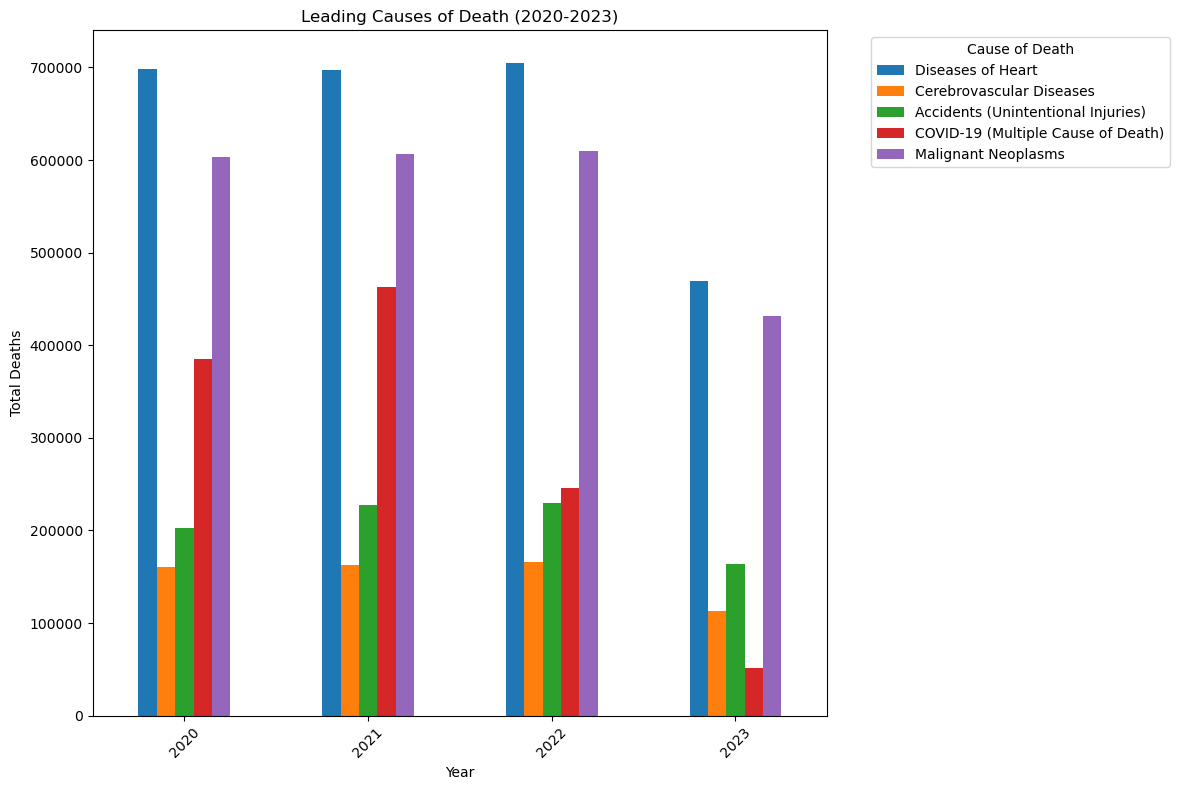

In [19]:
deaths_2020_2023 = deaths_df[deaths_df['Year'].between(2020, 2023)]

# Aggregate the total death counts by year and cause of death
death_counts_by_cause = deaths_2020_2023.groupby(['Year'])[['Diseases of Heart', 'Cerebrovascular Diseases', 'Accidents (Unintentional Injuries)', 'COVID-19 (Multiple Cause of Death)', 'Malignant Neoplasms']].sum()

# Plot the leading causes of death for each year
death_counts_by_cause.plot(kind='bar', stacked=False, figsize=(12, 8))
plt.title('Leading Causes of Death (2020-2023)')
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45)
plt.legend(title='Cause of Death', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

                                   Topic   DataValue  \
0                                Alcohol   12.345455   
1                                 Asthma   11.154545   
2                 Cardiovascular Disease   69.472517   
3                 Chronic Kidney Disease   71.909091   
4  Chronic Obstructive Pulmonary Disease   59.497525   
5                               Diabetes   43.881818   
6                           Older Adults    7.654659   
7                 Overarching Conditions  640.645455   

                                Disease  
0                                   NaN  
1  Other Diseases of Respiratory System  
2                     Diseases of Heart  
3                Chronic Kidney Disease  
4    Chronic Lower Respiratory Diseases  
5                     Diabetes Mellitus  
6                         Natural Cause  
7                                   NaN  

Merged Data Overview:
                                   Topic  DataValue  \
0                                 Asthm

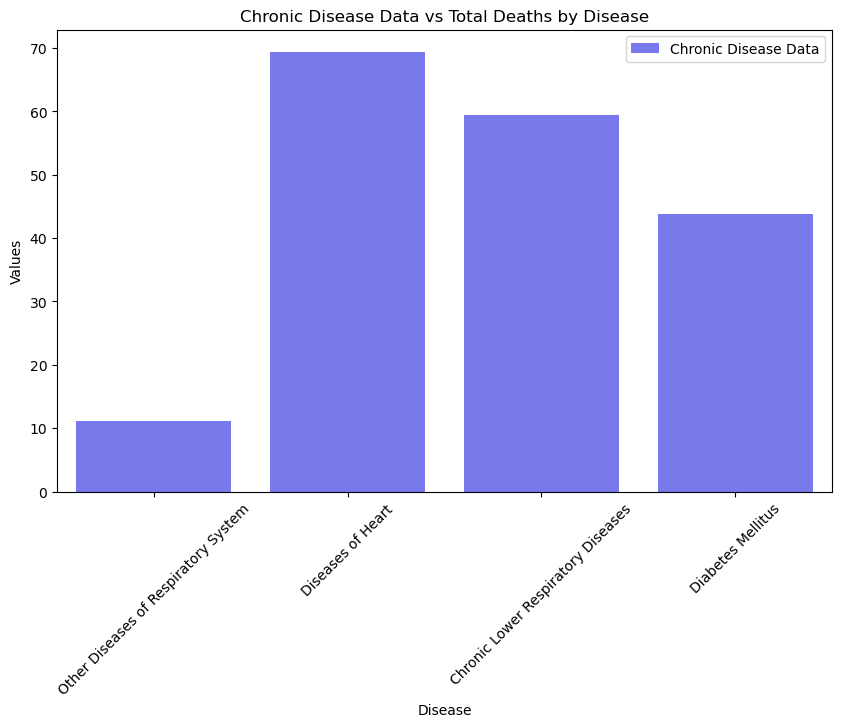

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming 'df_1' is the deaths data and 'df_2' is the chronic disease data
deaths_df = df_1
chronic_df = df_2

# Convert 'DataValue' to numeric to handle any non-numeric values
chronic_df['DataValue'] = pd.to_numeric(chronic_df['DataValue'], errors='coerce')

# Filter the chronic disease data for 'Crude Rate' type
chronic_filtered = chronic_df[chronic_df['DataValueType'] == 'Crude Rate']

# Aggregate chronic disease data by 'Topic' (across all years)
chronic_grouped = chronic_filtered.groupby(['Topic'])['DataValue'].mean().reset_index()

# Define a mapping between chronic disease topics and death causes
topic_to_disease_mapping = {
    'Diabetes': 'Diabetes Mellitus',
    'Cardiovascular Disease': 'Diseases of Heart',
    'Cerebrovascular Diseases': 'Cerebrovascular Diseases',
    'Chronic Kidney Disease': 'Chronic Kidney Disease',
    'Chronic Obstructive Pulmonary Disease': 'Chronic Lower Respiratory Diseases',
    'Asthma': 'Other Diseases of Respiratory System',
    'Older Adults': 'Natural Cause'
}

# Apply the mapping to rename 'Topic' in the chronic data
chronic_grouped['Disease'] = chronic_grouped['Topic'].map(topic_to_disease_mapping)
print(chronic_grouped)
# Aggregate death data by summing the relevant disease columns (across all years)
death_columns = ['Diabetes Mellitus', 'Diseases of Heart', 'Cerebrovascular Diseases','Chronic Lower Respiratory Diseases','Other Diseases of Respiratory System']
deaths_grouped = deaths_df[death_columns].sum().reset_index()

# Rename the columns of 'deaths_grouped' to match the disease names
deaths_grouped.columns = ['Disease', 'Total Deaths']

# Check merged data after applying the mapping
merged_df = pd.merge(chronic_grouped, deaths_grouped, on='Disease', how='inner')

# Check the merged data
# Inspect the merged dataset for any obvious pattern
print("\nMerged Data Overview:")
print(merged_df)

# Plotting the Data for better understanding
plt.figure(figsize=(10, 6))

# Plot the chronic disease data and death data for each disease
sns.barplot(x='Disease', y='DataValue', data=merged_df, color='blue', alpha=0.6, label='Chronic Disease Data')
sns.barplot(x='Disease', y='Total Deaths', data=merged_df, color='red', alpha=0.6, label='Total Deaths')

# Add labels and title
plt.title('Chronic Disease Data vs Total Deaths by Disease')
plt.xlabel('Disease')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.show()


                                     Chronic Disease  \
31                                            Asthma   
35                                            Asthma   
80             Chronic Obstructive Pulmonary Disease   
81             Chronic Obstructive Pulmonary Disease   
82             Chronic Obstructive Pulmonary Disease   
85             Chronic Obstructive Pulmonary Disease   
88             Chronic Obstructive Pulmonary Disease   
89             Chronic Obstructive Pulmonary Disease   
90             Chronic Obstructive Pulmonary Disease   
92             Chronic Obstructive Pulmonary Disease   
99                            Cardiovascular Disease   
100                           Cardiovascular Disease   
101                           Cardiovascular Disease   
103                           Cardiovascular Disease   
104                           Cardiovascular Disease   
107                           Cardiovascular Disease   
108                           Cardiovascular Dis

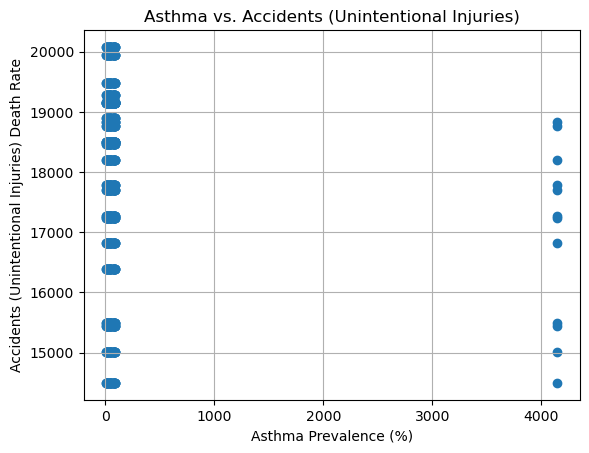

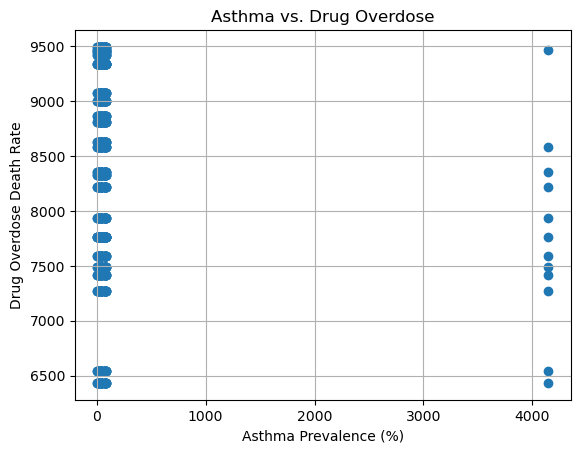

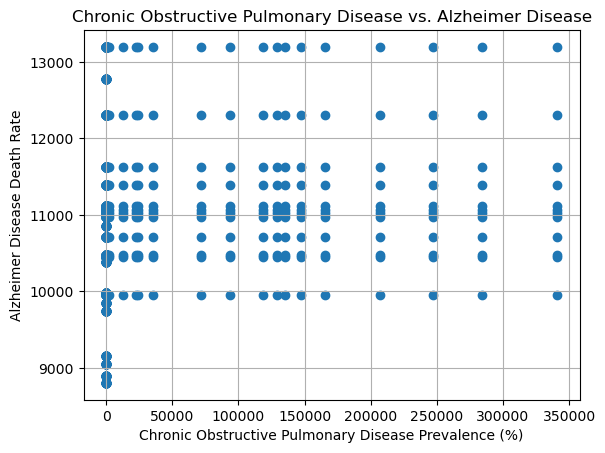

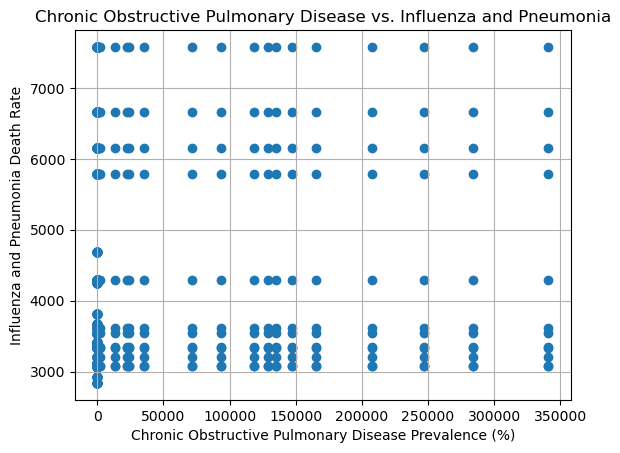

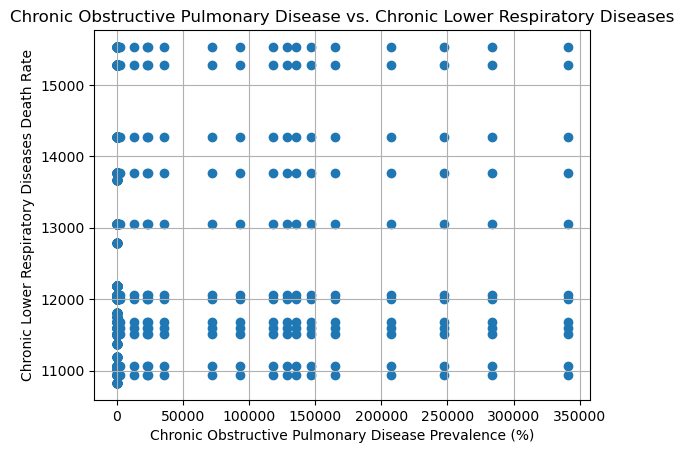

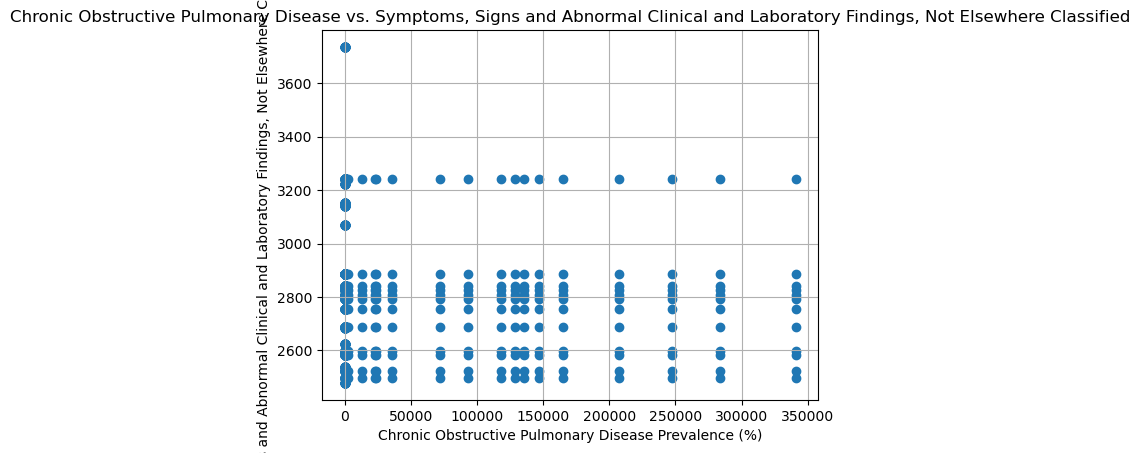

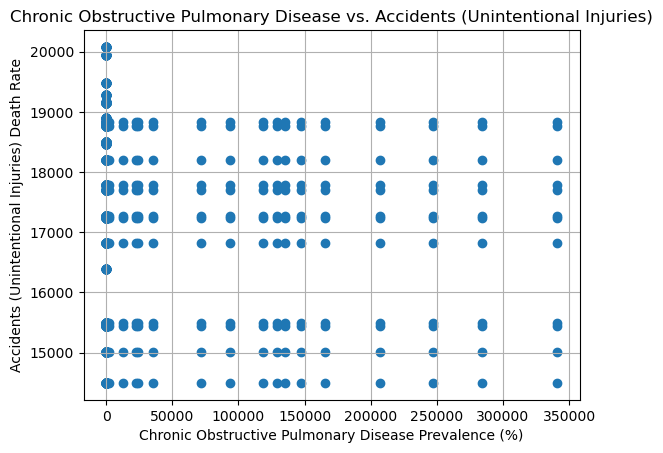

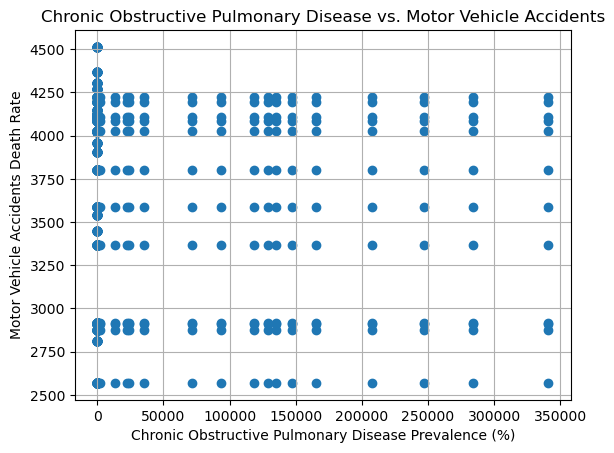

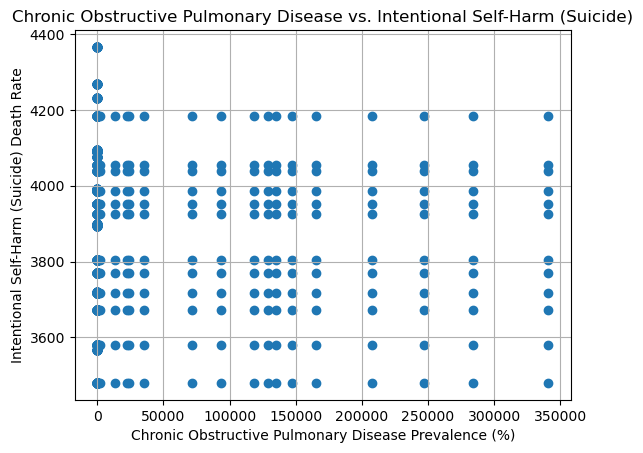

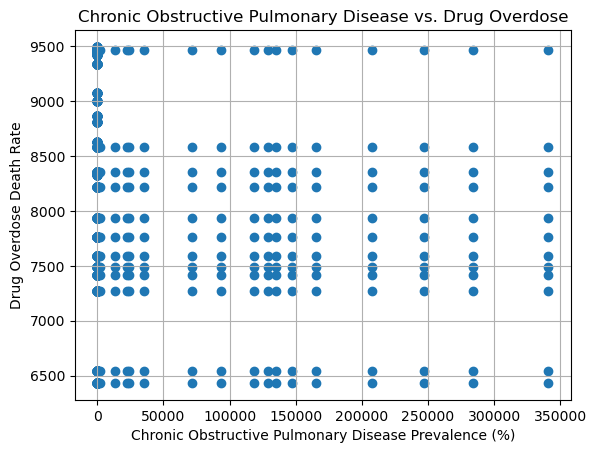

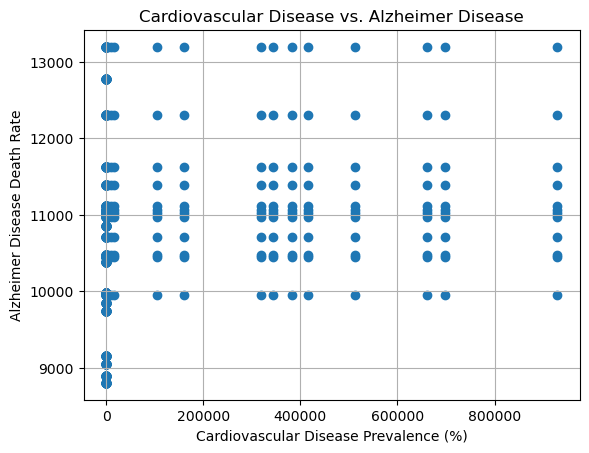

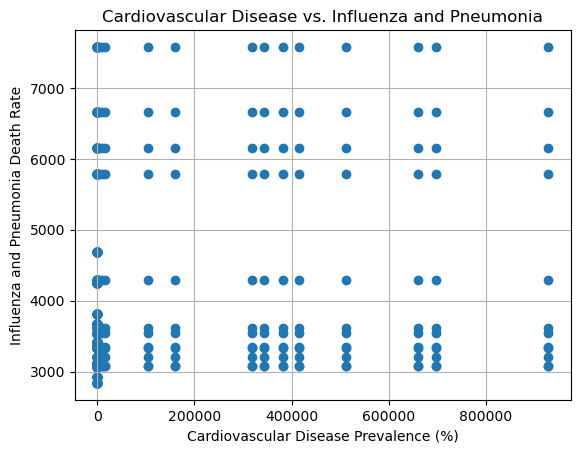

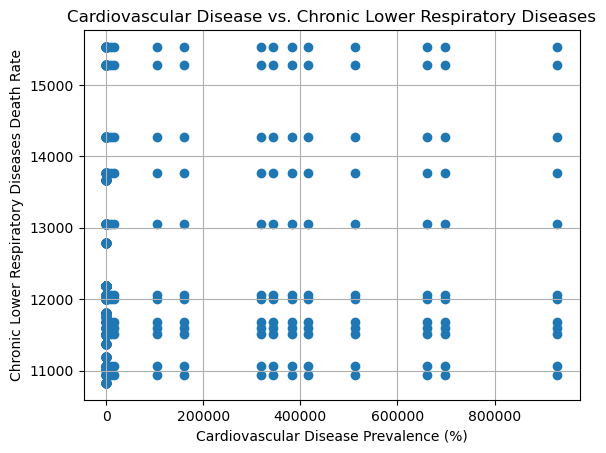

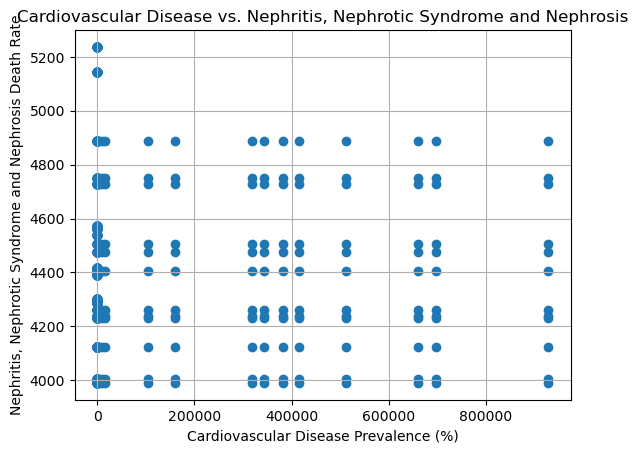

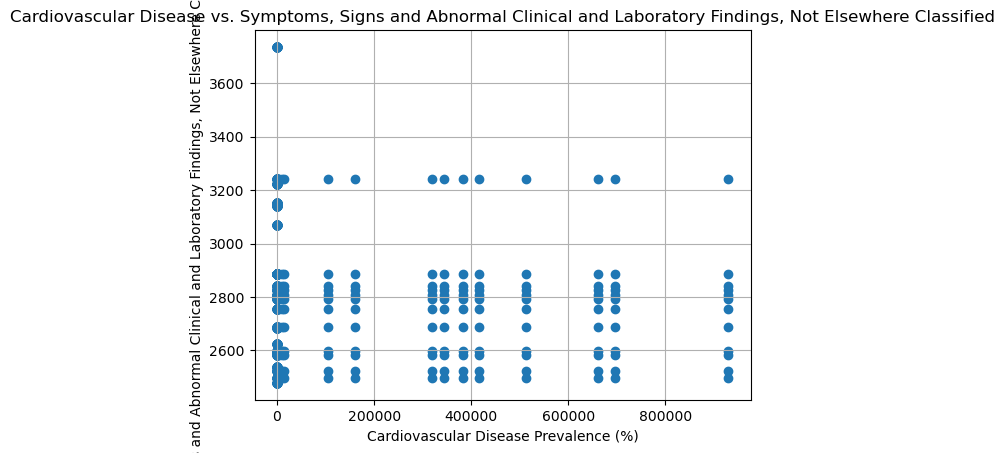

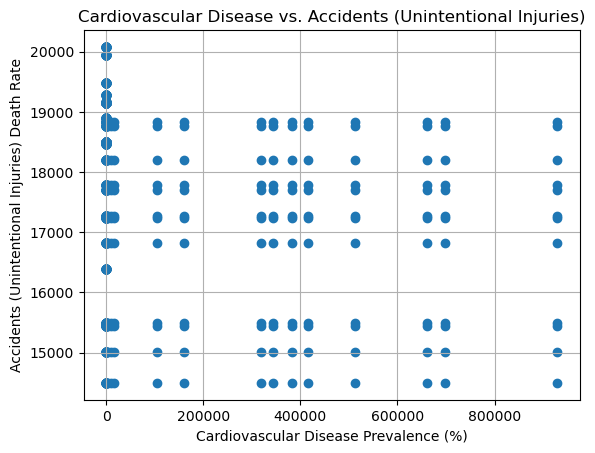

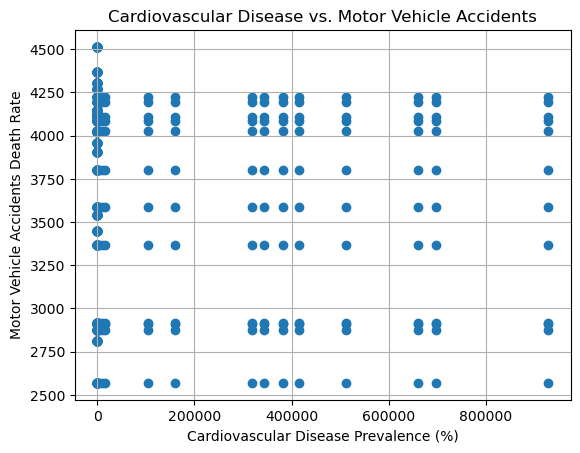

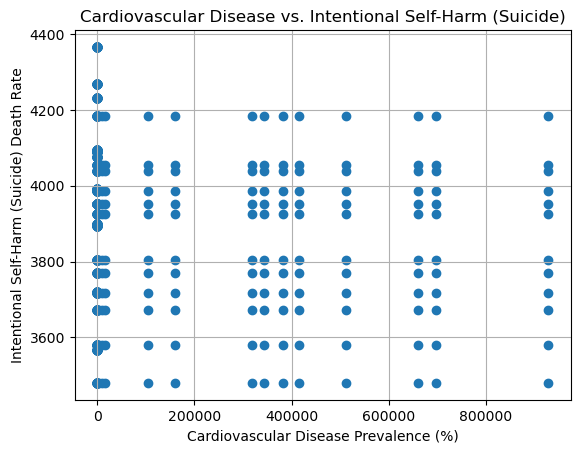

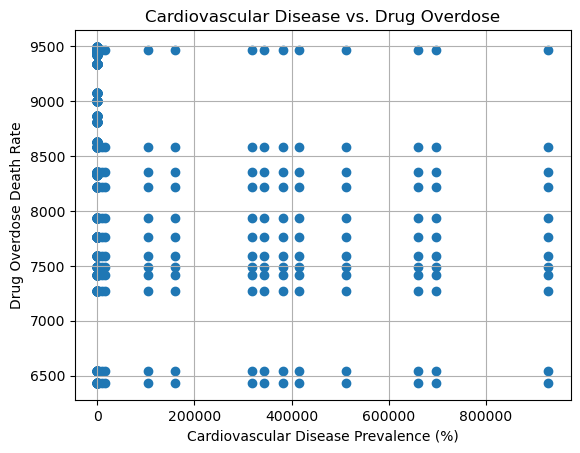

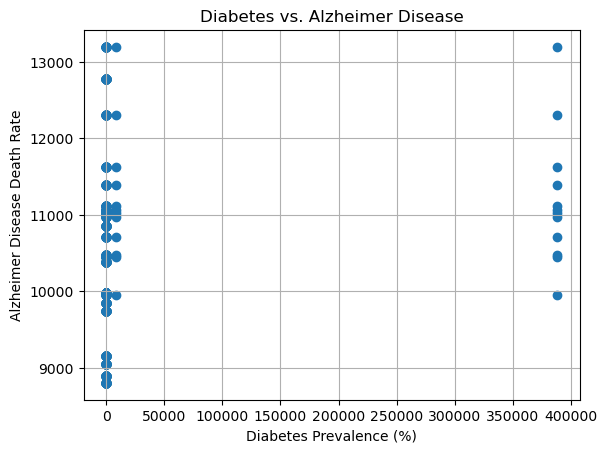

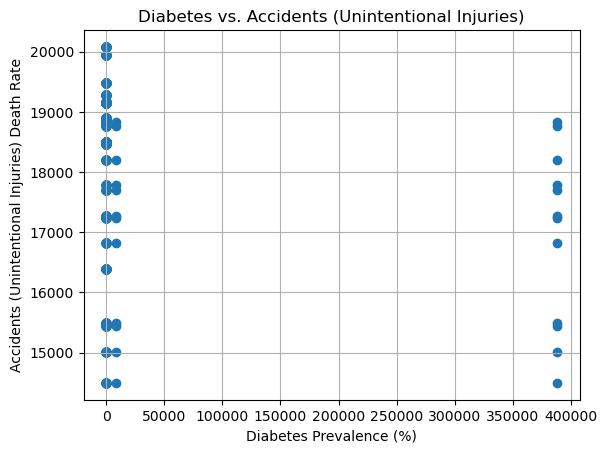

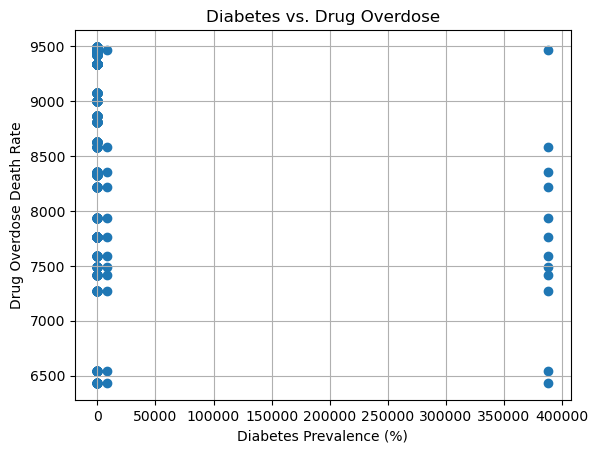

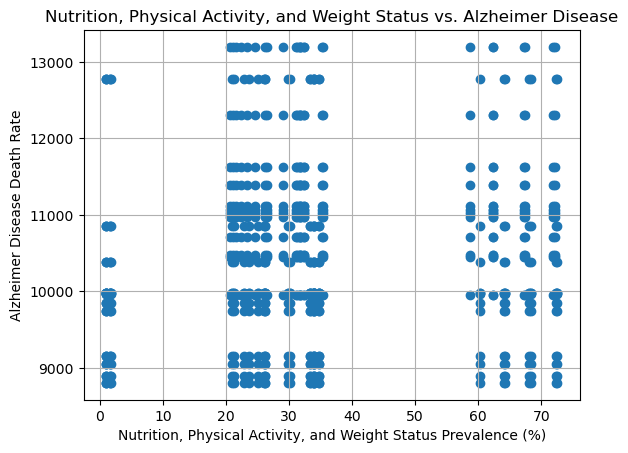

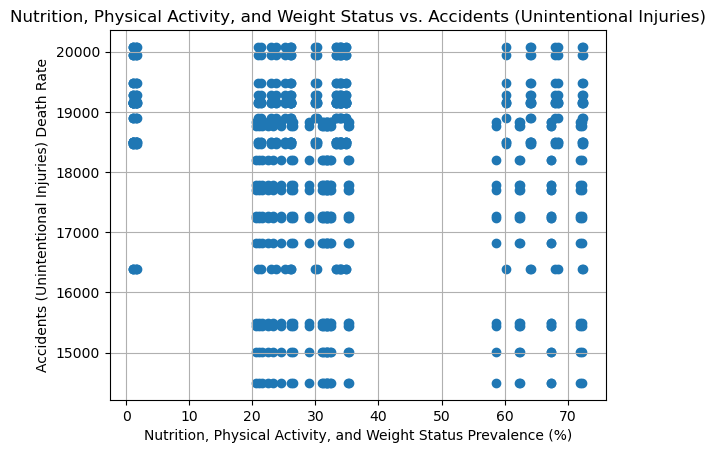

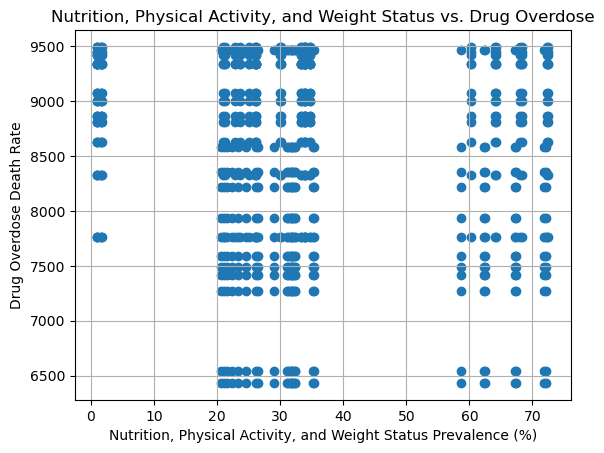

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

chronic = df_2
deaths = df_1

chronic['Year'] = chronic['YearStart']
merged = pd.merge(deaths, chronic, on=['Year'], how='inner')

# Initialize a dictionary for results
results = []

# Iterate over all chronic disease indicators and death causes
chronic_topics = chronic['Topic'].unique()
death_causes = deaths.columns[3:]  # All death causes after 'Year' and 'Month'

subsets = {}
for topic in chronic_topics:
    for cause in death_causes:
        # Filter data for the specific chronic disease and death cause
        subset = merged[(merged['Topic'] == topic) & (merged[cause].notna())]
        
        # Clean data
        subset = subset.dropna(subset=['DataValue', cause])
        subset = subset[~subset[['DataValue', cause]].isin([float('inf'), float('-inf')]).any(axis=1)]
        
        if not subset.empty:
            # Store subset for visualization
            subsets[(topic, cause)] = subset
            
            # Calculate correlation
            correlation, p_value = pearsonr(subset['DataValue'].astype(float), subset[cause].astype(float))
            
            # Append results
            results.append({'Chronic Disease': topic, 
                            'Death Cause': cause, 
                            'Correlation': correlation, 
                            'P-Value': p_value})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Filter significant correlations (p < 0.05)
significant_results = results_df[results_df['P-Value'] < 0.05]

# Save or display results
significant_results.to_csv('significant_correlations.csv', index=False)
print(significant_results)

# Visualize significant correlations
for _, row in significant_results.iterrows():
    topic = row['Chronic Disease']
    cause = row['Death Cause']
    
    subset = subsets[(topic, cause)]
    plt.scatter(subset['DataValue'], subset[cause])
    plt.title(f'{topic} vs. {cause}')
    plt.xlabel(f'{topic} Prevalence (%)')
    plt.ylabel(f'{cause} Death Rate')
    plt.grid(True)
    plt.show()


Significant results found: 1
Weak correlations found: 7


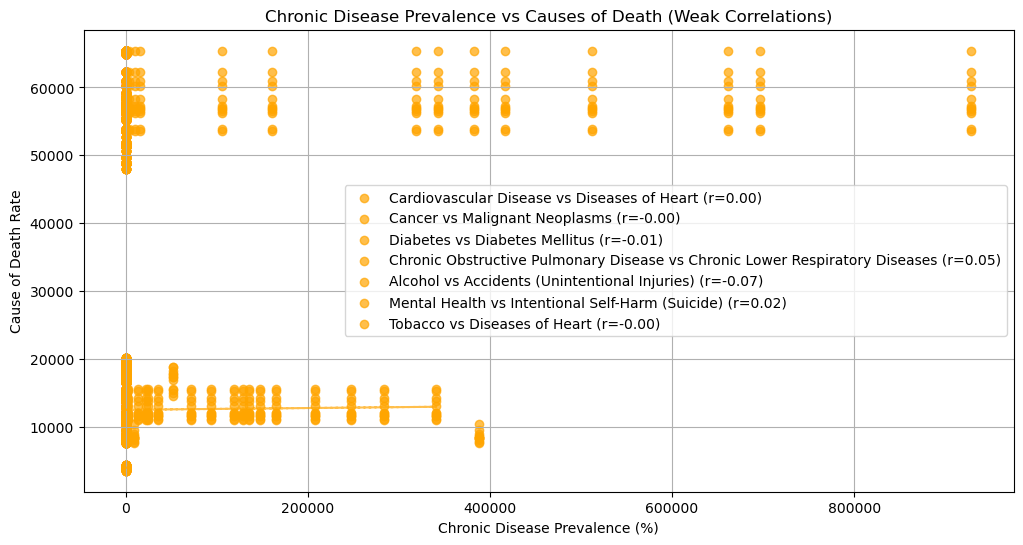

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define a dictionary of relevant chronic disease indicators and their corresponding causes of death
relevant_death_causes = {
    'Cardiovascular Disease': ['Diseases of Heart'],
    'Cancer': ['Malignant Neoplasms'],
    'Diabetes': ['Diabetes Mellitus'],
    'Chronic Obstructive Pulmonary Disease': ['Chronic Lower Respiratory Diseases'],
    'Alcohol': ['Accidents (Unintentional Injuries)'],
    'Mental Health': ['Intentional Self-Harm (Suicide)'],
    'Tobacco': ['Diseases of Heart']
}

# Assuming 'df_1' (deaths) and 'df_2' (chronic diseases) are your dataframes
chronic = df_2
deaths = df_1

chronic['Year'] = chronic['YearStart']
merged = pd.merge(deaths, chronic, on=['Year'], how='inner')

# Initialize a list to store results
results = []

# Function to plot scatter with trendline
def plot_with_trendline(x, y, label, color):
    # Filter NaN values for both x and y together
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]
    
    # Ensure x and y are numeric and have the same length
    x = pd.to_numeric(x, errors='coerce')
    y = pd.to_numeric(y, errors='coerce')
    
    if len(x) > 1 and len(y) > 1:  # Ensure at least two points for trendline
        plt.scatter(x, y, label=label, color=color, alpha=0.7)
        try:
            z = np.polyfit(x, y, 1)  # Fit a line (degree=1)
            p = np.poly1d(z)
            plt.plot(x, p(x), linestyle='--', color=color, alpha=0.7)
        except np.linalg.LinAlgError:
            print(f"Warning: Could not fit trendline for {label} due to numerical issues.")
    else:
        print(f"Skipping plot for {label}: insufficient data points.")

# Iterate over chronic disease indicators and their relevant death causes
for chronic_disease, death_causes in relevant_death_causes.items():
    for cause in death_causes:
        # Filter data for the specific chronic disease and death cause
        subset = merged[(merged['Topic'] == chronic_disease) & (merged[cause].notna())]
        
        # Clean data
        subset.loc[:, 'DataValue'] = pd.to_numeric(subset['DataValue'], errors='coerce')
        subset.loc[:, cause] = pd.to_numeric(subset[cause], errors='coerce')
        
        # Drop rows with NaN values
        subset = subset.dropna(subset=['DataValue', cause])
        
        # Remove infinite values
        subset = subset[~subset[['DataValue', cause]].isin([float('inf'), float('-inf')]).any(axis=1)]
        
        if not subset.empty:
            # Calculate correlation
            correlation, p_value = pearsonr(subset['DataValue'], subset[cause])
            
            # Append results
            results.append({'Chronic Disease': chronic_disease, 
                            'Death Cause': cause, 
                            'Correlation': correlation, 
                            'P-Value': p_value})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Filter significant correlations (p < 0.05)
significant_results = results_df[results_df['P-Value'] < 0.05]

# Print the number of significant results
print(f"Significant results found: {len(significant_results)}")

# Identify weak correlations (|correlation| < 0.3)
weak_correlations = results_df[results_df['Correlation'].abs() < 0.3]

# Print the number of weak correlations
print(f"Weak correlations found: {len(weak_correlations)}")

# Plot weak correlations with trendlines
plt.figure(figsize=(12, 6))
for _, row in weak_correlations.iterrows():
    topic = row['Chronic Disease']
    cause = row['Death Cause']
    
    # Check if subset is not empty before plotting
    subset = merged[(merged['Topic'] == topic) & (merged[cause].notna())]
    
    if not subset.empty:
        plot_with_trendline(subset['DataValue'], subset[cause], 
                            label=f'{topic} vs {cause} (r={row["Correlation"]:.2f})', 
                            color='orange')

# Customize plot
plt.title('Chronic Disease Prevalence vs Causes of Death (Weak Correlations)')
plt.xlabel('Chronic Disease Prevalence (%)')
plt.ylabel('Cause of Death Rate')
plt.legend(loc='best')
plt.grid(True)
plt.show()


Weak correlations found: 3


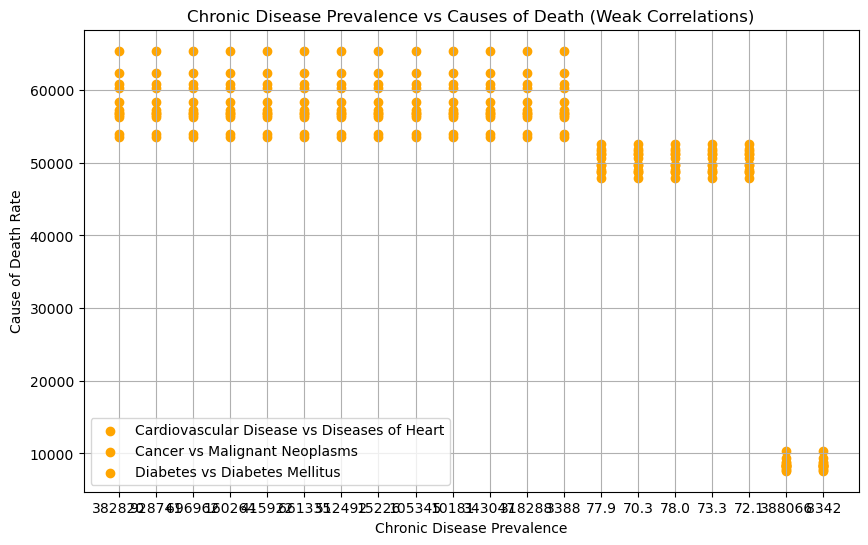

Weak Correlation Results:
          Chronic Disease          Death Cause   Correlation   P-Value  \
0  Cardiovascular Disease    Diseases of Heart  4.811710e-03  0.861352   
1                  Cancer  Malignant Neoplasms -1.214306e-17  1.000000   
2                Diabetes    Diabetes Mellitus -7.462174e-03  0.775430   

             DataValueType  
0                   Number  
1  Age-adjusted Prevalence  
2                   Number  


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.ticker import StrMethodFormatter

# Define a dictionary of relevant death causes for each chronic disease
relevant_death_causes = {
    'Cardiovascular Disease': ['Diseases of Heart'],
    'Cancer': ['Malignant Neoplasms'],
    'Respiratory Diseases': ['Chronic Lower Respiratory Diseases'],
    'Diabetes': ['Diabetes Mellitus']
}

# Initialize a list to store results
results = []

# Iterate over chronic disease indicators and their relevant death causes
for chronic_disease, death_causes in relevant_death_causes.items():
    for cause in death_causes:
        # Filter data for the specific chronic disease and death cause
        subset = merged[(merged['Topic'] == chronic_disease) & 
                        (merged[cause].notna())]
        
        # Clean data
        subset.loc[:, 'DataValue'] = pd.to_numeric(subset['DataValue'], errors='coerce')
        subset.loc[:, cause] = pd.to_numeric(subset[cause], errors='coerce')
        
        # Drop rows with NaN values
        subset = subset.dropna(subset=['DataValue', cause])
        
        # Remove infinite values
        subset = subset[~subset[['DataValue', cause]].isin([float('inf'), float('-inf')]).any(axis=1)]
        
        if not subset.empty:
            # Calculate correlation
            correlation, p_value = pearsonr(subset['DataValue'], subset[cause])
            
            # Append results
            results.append({'Chronic Disease': chronic_disease, 
                            'Death Cause': cause, 
                            'Correlation': correlation, 
                            'P-Value': p_value, 
                            'DataValueType': subset['DataValueType'].iloc[0]})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Identify weak correlations (|correlation| < 0.3)
weak_correlations = results_df[results_df['Correlation'].abs() < 0.3]

# Print the number of weak correlations
print(f"Weak correlations found: {len(weak_correlations)}")

# Visualize weak correlations
plt.figure(figsize=(10, 6))

# Plot weak correlations in orange
for _, row in weak_correlations.iterrows():
    topic = row['Chronic Disease']
    cause = row['Death Cause']
    data_type = row['DataValueType']
    
    # Check if subset is not empty before plotting
    subset = merged[(merged['Topic'] == topic) & 
                    (merged['DataValueType'] == data_type) & 
                    (merged[cause].notna())]
    
    if not subset.empty:
        plt.scatter(subset['DataValue'], subset[cause], color='orange', label=f'{topic} vs {cause}')

# Customize plot
plt.title('Chronic Disease Prevalence vs Causes of Death (Weak Correlations)')
plt.xlabel('Chronic Disease Prevalence')
plt.ylabel('Cause of Death Rate')

# Adjust y-axis to show rounded-off values
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))  # Round to nearest integer
plt.grid(True)

# Add legend to differentiate between weak correlations
plt.legend(loc='best')

# Show plot
plt.show()

# Print the weak correlation results
print("Weak Correlation Results:")
print(weak_correlations)


Significant results found: 1
Weak correlations found: 7
Strong correlations found: 0
Skipping plot for Cardiovascular Disease vs Diseases of Heart (r=0.00): mismatched data lengths.
Skipping trendline for Cancer vs Malignant Neoplasms (r=-0.00): correlation too weak.
Skipping plot for Diabetes vs Diabetes Mellitus (r=-0.01): mismatched data lengths.
Skipping plot for Alcohol vs Accidents (Unintentional Injuries) (r=-0.07): mismatched data lengths.
Skipping trendline for Mental Health vs Intentional Self-Harm (Suicide) (r=0.02): correlation too weak.
Skipping plot for Tobacco vs Diseases of Heart (r=-0.00): mismatched data lengths.


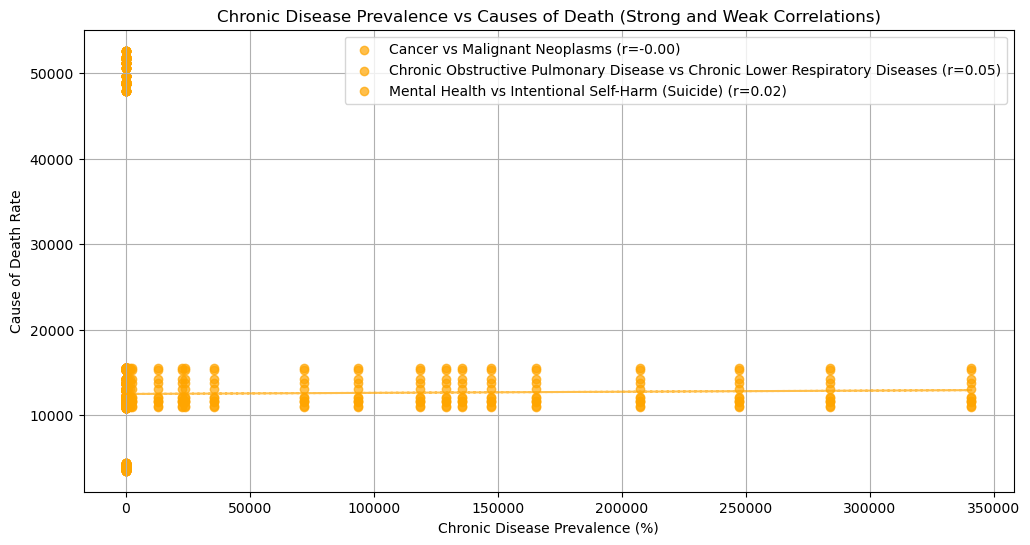

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define a dictionary of relevant chronic disease indicators and their corresponding causes of death
relevant_death_causes = {
    'Cardiovascular Disease': ['Diseases of Heart'],
    'Cancer': ['Malignant Neoplasms'],
    'Diabetes': ['Diabetes Mellitus'],
    'Chronic Obstructive Pulmonary Disease': ['Chronic Lower Respiratory Diseases'],
    'Alcohol': ['Accidents (Unintentional Injuries)'],
    'Mental Health': ['Intentional Self-Harm (Suicide)'],
    'Tobacco': ['Diseases of Heart']
}

# Assuming 'df_1' (deaths) and 'df_2' (chronic diseases) are your dataframes
chronic = df_2
deaths = df_1

chronic['Year'] = chronic['YearStart']
merged = pd.merge(deaths, chronic, on=['Year'], how='inner')

# Initialize a list to store results
results = []

# Function to plot scatter with trendline
def plot_with_trendline(x, y, label, color):
    # Remove NaN and Inf values for both x and y together
    mask = x.notna() & y.notna() & ~x.isin([float('inf'), float('-inf')]) & ~y.isin([float('inf'), float('-inf')])
    x, y = x[mask], y[mask]
    
    # Ensure x and y are numeric and have the same length
    x = pd.to_numeric(x, errors='coerce')
    y = pd.to_numeric(y, errors='coerce')
    
    # Drop any remaining NaN or Inf values after conversion to numeric
    x = x.dropna()
    y = y.dropna()

    # Ensure that both x and y have the same length
    if len(x) == len(y) and len(x) > 1:  # Ensure at least two points for trendline
        plt.scatter(x, y, label=label, color=color, alpha=0.7)
        try:
            # Calculate Pearson correlation after ensuring both arrays are clean
            correlation, _ = pearsonr(x, y)
            if abs(correlation) > 0.05:  # Only fit trendline for non-negligible correlation
                z = np.polyfit(x, y, 1)  # Fit a line (degree=1)
                p = np.poly1d(z)
                plt.plot(x, p(x), linestyle='--', color=color, alpha=0.7)
            else:
                print(f"Skipping trendline for {label}: correlation too weak.")
        except np.linalg.LinAlgError:
            print(f"Warning: Could not fit trendline for {label} due to numerical issues.")
    else:
        print(f"Skipping plot for {label}: mismatched data lengths.")

# Iterate over chronic disease indicators and their relevant death causes
for chronic_disease, death_causes in relevant_death_causes.items():
    for cause in death_causes:
        # Filter data for the specific chronic disease and death cause
        subset = merged[(merged['Topic'] == chronic_disease) & (merged[cause].notna())]
        
        # Clean data
        subset.loc[:, 'DataValue'] = pd.to_numeric(subset['DataValue'], errors='coerce')
        subset.loc[:, cause] = pd.to_numeric(subset[cause], errors='coerce')
        
        # Drop rows with NaN or Inf values in both columns
        subset = subset.dropna(subset=['DataValue', cause])
        subset = subset[~subset[['DataValue', cause]].isin([float('inf'), float('-inf')]).any(axis=1)]
        
        if not subset.empty:
            # Calculate correlation
            correlation, p_value = pearsonr(subset['DataValue'], subset[cause])
            
            # Append results
            results.append({'Chronic Disease': chronic_disease, 
                            'Death Cause': cause, 
                            'Correlation': correlation, 
                            'P-Value': p_value})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Filter significant correlations (p < 0.05)
significant_results = results_df[results_df['P-Value'] < 0.05]

# Print the number of significant results
print(f"Significant results found: {len(significant_results)}")

# Identify weak correlations (|correlation| < 0.3)
weak_correlations = results_df[results_df['Correlation'].abs() < 0.3]

# Identify strong correlations (|correlation| >= 0.3)
strong_correlations = results_df[results_df['Correlation'].abs() >= 0.3]

# Print the number of weak correlations
print(f"Weak correlations found: {len(weak_correlations)}")
print(f"Strong correlations found: {len(strong_correlations)}")

# Plot strong correlations with trendlines
plt.figure(figsize=(12, 6))
for _, row in strong_correlations.iterrows():
    topic = row['Chronic Disease']
    cause = row['Death Cause']
    
    # Check if subset is not empty before plotting
    subset = merged[(merged['Topic'] == topic) & (merged[cause].notna())]
    
    if not subset.empty:
        plot_with_trendline(subset['DataValue'], subset[cause], 
                            label=f'{topic} vs {cause} (r={row["Correlation"]:.2f})', 
                            color='blue')

# Plot weak correlations with trendlines
for _, row in weak_correlations.iterrows():
    topic = row['Chronic Disease']
    cause = row['Death Cause']
    
    # Check if subset is not empty before plotting
    subset = merged[(merged['Topic'] == topic) & (merged[cause].notna())]
    
    if not subset.empty:
        plot_with_trendline(subset['DataValue'], subset[cause], 
                            label=f'{topic} vs {cause} (r={row["Correlation"]:.2f})', 
                            color='orange')

# Customize plot
plt.title('Chronic Disease Prevalence vs Causes of Death (Strong and Weak Correlations)')
plt.xlabel('Chronic Disease Prevalence (%)')
plt.ylabel('Cause of Death Rate')
plt.legend(loc='best')
plt.grid(True)
plt.show()
